In [46]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas_datareader.data as web
from sklearn import linear_model

class ScikitBacktest(object):
    def __init__(self, sym):
        self.lags = 5
        self.symbol = sym
        self.get_data()
        self.lm = linear_model.LogisticRegression(C=1e3)
        
    def get_data(self):
        d = web.DataReader(self.symbol, data_source='yahoo')['Adj Close']
        d = pd.DataFrame(d)
        d.columns = [self.symbol]
        d['returns'] = np.log(d / d.shift(1))
        self.data = d
        
    def select_data(self, start, end):
        d = self.data[(self.data.index >= start) & (self.data.index <= end)].copy()
        return d
    
    def get_matrix(self, start, end):
        d = self.select_data(start, end)
        m = np.zeros((self.lags+1, len(d)-self.lags))
        for i in range(self.lags+1):
            if i == self.lags:
                m[i] = d.returns.values[i:]
            else:
                m[i] = d.returns.values[i:i-self.lags]
        self.matrix = m
        
    def fit_model(self, start, end):
        self.get_matrix(start, end)
        self.lm.fit(self.matrix[:self.lags].T, np.sign(self.matrix[self.lags]))
        
    def predict_moves(self, start, end):
        self.get_matrix(start, end)
        pred = self.lm.predict(self.matrix[:self.lags].T)
        return pred
    
    def run_strategy(self, start_tr, end_tr, start_te, end_te, lags):
        self.lags = lags
        self.fit_model(start_tr, end_tr)
        pred = self.predict_moves(start_te, end_te)
        d = self.select_data(start_te, end_te)
        d['pred'] = 0.0
        d['pred'].ix[self.lags:] = pred
        d['strategy'] = d.pred * d.returns
        title = '%s to %s for %d lags' % (start_te, end_te, self.lags)
        d[['returns', 'strategy']].ix[self.lags:].cumsum().apply(np.exp).plot(title=title)
        return d

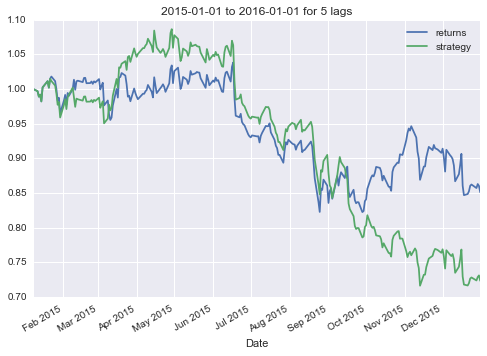

In [63]:
bt = ScikitBacktest('ORCL')
bt.get_data()
df = bt.run_strategy('2013-01-01','2014-01-01', '2015-01-01', '2016-01-01',5)

In [64]:
df.head()

,ORCL,returns,pred,strategy
Date,,,,
2015-01-02,43.051115,-0.014334,0.0,-0.0
2015-01-05,42.447366,-0.014123,0.0,-0.0
2015-01-06,42.009161,-0.010377,0.0,-0.0
2015-01-07,42.018901,0.000232,0.0,0.0
2015-01-08,42.272084,0.006007,0.0,0.0
